In [2]:
using QuantEcon
using LinearAlgebra
using SimplePCHIP
using SparseArrays
using Arpack
using Printf

┌ Info: Precompiling QuantEcon [fcd29c91-0bd7-5a09-975d-7ac3f643a60c]
└ @ Base loading.jl:1242
┌ Info: Precompiling SimplePCHIP [3779923d-9ba7-5a90-82c8-bfb242b3cfa3]
└ @ Base loading.jl:1242


In [3]:
struct Par{TI<:Integer, TF<:AbstractFloat, TV<:Vector}
    GAMMA::TF
    PSI::TF
    BL::TF
    MU::TF
    SUB_MON_COM::TF

    TAU_BAR::TV
    B4YSS::TF

    MAX_A::TF
    MIN_A::TF
    MAX_A_NS::TF
    MIN_A_NS::TF
    N_A::TI
    N_A_NS::TI
    GRID_A_SHIFT::TF

    RHO_Z::TF
    VAR_Z_INN::TF
    N_Z::TI

    MAX_BETA_ITER::TI
    MAX_EGM_ITER::TI
    MAX_EGM_CONST_ITER::TI
    BETA_ERR_TOL::TF
    EGM_ERR_TOL::TF
    EGM_CONST_ERR_TOL::TF
    NS_ERR_TOL::TF
end

In [4]:
function HH_opt_EGM(beta,p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c_init,pf_n_init,pf_sav_init)
    
    pf_c = pf_c_init
    pf_n = pf_n_init
    pf_sav = pf_sav_init

    # WHILE LOOP: iterate until the policy functions converge
    for EGM_iter = 1:p.MAX_EGM_ITER

        pf_c_int = zeros(p.N_A+1,p.N_Z)
        endog_grid_a = zeros(p.N_A+1,p.N_Z)

        # Assuming that the borrowing constraint is not binding, solve for the policy functions
        for i_z = 1:p.N_Z # Fix z

            zToday      = grid_z[i_z]
            cond_prob_z = prob_z[i_z,:]

            for i_a = 1:p.N_A

                # EGM: construct a grid for a', rather than a grid for a
                #     solve for the value of a that would have led to the choice a'
                aTomorrow = grid_a[i_a]

                # Compute the expected marginal utility of consumption using a', and derive consumption today from the Euler equation
                # Note that here we skip a root-finding algorithm, thereby making the algorithm much more efficient than the usual policy function iteration!
                EMUc = 0.0
                for j_z = 1:p.N_Z
                    EMUc = EMUc + beta*RToday*(cond_prob_z[j_z]*pf_c[i_a,j_z]^(-p.GAMMA))
                end

                cToday = EMUc^(-1.0/p.GAMMA)

                # Derive labor supply today from the labor supply equation
                nToday = (wToday*zToday*cToday^(-p.GAMMA))^(1.0/p.PSI)

                # Derive today's asset from the budget constraint. This current asset level is called the endogenous gridpoints
                aToday = cToday + aTomorrow/RToday - wToday*zToday*nToday + tauToday*p.TAU_BAR[i_z] - dToday

                # Store the values
                pf_c_int[i_a,i_z]     = cToday
                endog_grid_a[i_a,i_z] = aToday

            end # a

        end # z

        # The following is used for evaluating the new policy functions at the exogenous gridpoints using the pchip interpolation if the exogenous gridpoints are beyond the maximum endogenous gridpoints
        # Here, pf_c_int(N_A+1,:) is linearly extrapolated
        for i_z = 1:p.N_Z
            endog_grid_a[p.N_A+1,i_z] = 1e+5 # Note(20190825): Nakata-san set this as 1e8, rather than 1d5.
            pf_c_int[p.N_A+1,i_z] = pf_c_int[p.N_A,i_z]
                + ((pf_c_int[p.N_A,i_z] - pf_c_int[p.N_A-1,i_z]) / (endog_grid_a[p.N_A,i_z] - endog_grid_a[p.N_A-1,i_z]))
                *(endog_grid_a[p.N_A+1,i_z]-endog_grid_a[p.N_A,i_z])
            # The coefficient of the second term is just a slope
        end

        pf_c_new = zeros(p.N_A,p.N_Z)
        pf_n_new = zeros(p.N_A,p.N_Z)
        pf_sav_new = zeros(p.N_A,p.N_Z)

        # Evaluate the new policy functions at the exogenous gridpoints (or the original gridpoints).
        for i_z = 1:p.N_Z # Fix z

            zToday      = grid_z[i_z]
            cond_prob_z = prob_z[i_z,:]

            # fit spline for each i_z
            pchip_c = interpolate(endog_grid_a[:,i_z],pf_c_int[:,i_z])
            
            for i_a = 1:p.N_A

                aToday = grid_a[i_a]

                # In this case, endog_grid_a(1,:) is the value of bond holdings that induces the borrowing constraint to bind next period.
                # This is because the far left gridpoint in this program is set to the borrowing limit.
                if (aToday > endog_grid_a[1,i_z])

                    # The borrowing constraint does not bind.
                    # shape-preserving spline!!!
                    # only evaluate spline
                    cToday = pchip_c(aToday)

                    nToday = (wToday*zToday*cToday^(-p.GAMMA))^(1.0/p.PSI)

                    aTomorrow = (aToday + wToday*zToday*nToday - tauToday*p.TAU_BAR[i_z] + dToday - cToday)*RToday

                else

                    # The borrowing costraint binds. Use the subroutine 'EGMConstrained' to compute cToday and nToday when the borrowing constraint is binding.
                    aTomorrow = p.BL

                    # Call 'EGMConstrained' to obtain the values of cToday and nToday when the borrowing constraint is binding.
                    cToday,nToday = EGMconstrained(p,aToday,zToday,RToday,wToday,tauToday,dToday,i_z)

                end

    #             % Obtain the new policy functions for consumption, labor supply, and savings as well as the associated value function.
    #             % Preparation for the value function
    # %             Ev_int = 0d0
    # %             do j_z = 1, Par%N_Z
    # %                 call interp1_pchip(vTomorrow, Par%N_A, grid_a, aTomorrow, values(:,j_z))
    # %                 Ev_int = Ev_int + cond_prob_z(j_z)*vTomorrow
    # %             end do
    # %             vToday = cToday**(1d0 - Par%GAMMA)/(1d0 - Par%GAMMA) - nToday**(1d0 + Par%PSI)/(1d0 + Par%PSI) + beta*Ev_int
    # %             disp([i_a i_z grid_a(i_a) cToday nToday aTomorrow]);
    # %             pause

                pf_c_new[i_a,i_z]   = cToday
                pf_n_new[i_a,i_z]   = nToday
                pf_sav_new[i_a,i_z] = aTomorrow
    #             %values_new(i_a,i_z) = vToday

            end # a

        end # z

        # Evaluate convergence.
        EGM_err_c   = maximum(maximum(abs.(pf_c_new - pf_c)))
        EGM_err_n   = maximum(maximum(abs.(pf_n_new - pf_n)))
        EGM_err_sav = maximum(maximum(abs.(pf_sav_new - pf_sav)))
        EGM_err     = maximum([EGM_err_c, EGM_err_n, EGM_err_sav])

#         println([EGM_iter,EGM_err])

    #     if (mod(EGM_iter,50)==0); disp([EGM_iter EGM_err]); end;
    # % 
    # %     ! write(*,*) "------------------------------------------------------"
    # %     ! write(*,*) "AT ITERATION   = ", EGM_iter
    # %     ! write(*,*) "MAX DIFFERENCE = ", EGM_err
    # %     ! write(*,*) "------------------------------------------------------"
    # % 
        if ( EGM_err < p.EGM_ERR_TOL ); break; end

        # Update the policy functions for consumption, labor supply, and savings as well as the associated value function
        pf_c   = pf_c_new
        pf_n   = pf_n_new
        pf_sav = pf_sav_new
    # %     values = values_new
    # % 
    end # End of WHILE LOOP over the policy functions
    
    return pf_c,pf_n,pf_sav

end

HH_opt_EGM (generic function with 1 method)

In [5]:
function EGMconstrained(p,aToday,zToday,RToday,wToday,tauToday,dToday,i_z)

    # Initial guess of the value of labor supply and the associated consumption value.
    nToday = 0.6

    cToday = aToday + wToday*zToday*nToday - tauToday*p.TAU_BAR[i_z] + dToday - p.BL/RToday

    labor_eq_diff = (cToday^(-p.GAMMA))*wToday*zToday - nToday^p.PSI # labor_eq_diff denotes the difference of the labor supply equation.

    # Initialization
    EGM_const_err = 100.0

    # WHILE LOOP: iterate until we find a pair of labor supply and consumption that satisfies the labor supply equation.
    #             Here we use the Newton-Raphson method.
    for EGM_const_iter = 1:p.MAX_EGM_CONST_ITER

        labor_eq_adj  = -p.GAMMA*(cToday^(-p.GAMMA-1.0))*(wToday*zToday)^2.0 - p.PSI*nToday^(p.PSI-1.0)

        nToday        = nToday - labor_eq_diff/labor_eq_adj

        cToday        = aToday + zToday*wToday*nToday - tauToday*p.TAU_BAR[i_z] + dToday - p.BL/RToday

        labor_eq_diff = (cToday^(-p.GAMMA))*wToday*zToday - nToday^p.PSI

        EGM_const_err = abs(labor_eq_diff)

    # %     ! write(*,*) "------------------------------------------------------"
    # %     ! write(*,*) "AT ITERATION   = ", EGM_const_iter
    # %     ! write(*,*) "DIFFERENCE = ", EGM_const_err
    # %     ! write(*,*) "------------------------------------------------------"
        if (EGM_const_err < p.EGM_CONST_ERR_TOL); break; end

    end

    return cToday,nToday
    
end

# % if (EGM_const_err >= Par%EGM_CONST_ERR_TOL) then
# %     write(*,*) "EGMConstrained did not converge"
# % end if

EGMconstrained (generic function with 1 method)

In [6]:
function HH_dist(beta,p,grid_a,grid_a_NS,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav)

    AA = spzeros(p.N_A_NS*p.N_Z,p.N_A_NS*p.N_Z)

    # Non-stochastic simulations for period t.
    for i_z = 1:p.N_Z # Fix i_z

        zToday = grid_z[i_z]

        pchip_sav = interpolate(grid_a,pf_sav[:,i_z])
        
        for i_a_NS = 1:p.N_A_NS # Fix i_a_NS

            # NOTE: 
            aToday = min(p.MAX_A_NS,grid_a_NS[i_a_NS])

            # Compute savings of households whose state variables are a_{i_a_NS} and z_{i_z}, using the policy function for savings.
            aTomorrow = pchip_sav(aToday)

            indexToday = p.N_A_NS*(i_z-1) + i_a_NS

            # Find the index j such that grid_a_NS(j) < aTomorrow <= grid_a_NS(j+1).
            global j_a_NS
            for k_a_NS = 1:p.N_A_NS-1

                if (aTomorrow <= p.MIN_A_NS) # Make sure that MIN_A_NS = grid_a_NS(1) (= BL)
                    j_a_NS = 0
                    break
                elseif (grid_a_NS[k_a_NS] < aTomorrow && aTomorrow <= grid_a_NS[k_a_NS+1])
                    j_a_NS = k_a_NS
                    break
                elseif (aTomorrow > p.MAX_A_NS)
                    j_a_NS = p.N_A_NS
                    break
                end

            end

            # Redistribute the current mass, Hist(i_a_NS,i_z), to the points (grid_a_NS(j), z(1)), (grid_a_NS(j), z(2)), (grid_a_NS(j), z(3)),
            # (grid_a_NS(j+1), z(1)), (grid_a_NS(j+1), z(2)), and (grid_a_NS(j+1), z(3)) according to the weights, weight_NS*prob(i_z, 1),  weight_NS*prob(i_z, 2),  weight_NS*prob(i_z, 3),
            # (1d0 - weight_NS)*prob(i_z, 1),  (1d0 - weight_NS)*prob(i_z, 2), and (1d0 - weight_NS)*prob(i_z, 3).
            # Note that 'Hist_up' denotes the end-of-period t distribution, while 'Hist' denotes the beginning-of-period t distribution.
            if ( j_a_NS == 0 )

                for j_z = 1:p.N_Z #

                    indexTomorrow = p.N_A_NS*(j_z-1) + 1
                    AA[indexToday,indexTomorrow] = prob_z[i_z,j_z]

                end

            elseif ( j_a_NS == p.N_A_NS )

                for j_z = 1:p.N_Z #

                    indexTomorrow = p.N_A_NS*(j_z-1) + p.N_A_NS;
                    AA[indexToday,indexTomorrow] = prob_z[i_z,j_z]

                end

            else

                weight_NS = 1.0 - ((aTomorrow - grid_a_NS[j_a_NS])/(grid_a_NS[j_a_NS+1] - grid_a_NS[j_a_NS]))

                for j_z = 1:p.N_Z

                    indexTomorrow = p.N_A_NS*(j_z-1) + j_a_NS
                    AA[indexToday,indexTomorrow] = prob_z[i_z,j_z]*weight_NS
                    AA[indexToday,indexTomorrow+1] = prob_z[i_z,j_z]*(1.0-weight_NS)

                end

            end

        end # a

    end # z

    temp = copy(transpose(AA))
    d,v = eigs(temp,nev=1,tol=p.NS_ERR_TOL)
    dist = v/sum(v)
    dist = real(dist)
    dist = reshape(dist,(p.N_A_NS,p.N_Z))

    meanC = 0.0
    meanN = 0.0
    meanA = 0.0
    # %	meanV = 0.0;

    for i_z = 1:p.N_Z

        zToday = grid_z[i_z]

        pchip_c = interpolate(grid_a,pf_c[:,i_z])
        pchip_n = interpolate(grid_a,pf_n[:,i_z])
        pchip_sav = interpolate(grid_a,pf_sav[:,i_z])

        for i_a_NS = 1:p.N_A_NS

            aToday = min(p.MAX_A_NS,grid_a_NS[i_a_NS])

            cToday = pchip_c(aToday) #pchip(grid_a,pf_c(:,i_z),aToday)
            nToday = pchip_n(aToday) #pchip(grid_a,pf_n(:,i_z),aToday)
            aTomorrow = pchip_sav(aToday) #pchip(grid_a,pf_sav(:,i_z),aToday)
            if (aTomorrow < p.BL)
                aTomorrow = p.BL
            end

            meanC = meanC + dist[i_a_NS,i_z]*cToday
            meanN = meanN + dist[i_a_NS,i_z]*zToday*nToday # Note: meanN is calculated as the mean value of the 'effective' labor supply, labor supply multiplied by idiosyncratic labor productivity.
            meanA = meanA + dist[i_a_NS,i_z]*aTomorrow # Note: The original code uses aToday instead of aTomorrow, which was wrong.
    # %			meanV = meanV + (dist(i_a_NS,i_z)/sum(dist))*vToday

        end

    end
   
    return dist,meanC,meanN,meanA
    
end

HH_dist (generic function with 1 method)

In [7]:
GAMMA = 2.0
PSI = 2.0
BL = 0.0
MU = 1.2
SUB_MON_COM = (MU-1.0)/MU

TAU_BAR = [0, 0, 2.031292672482304]
B4YSS = 5.5/4.0

MAX_A = 75.0
MIN_A = 0.0
MAX_A_NS = 75.0
MIN_A_NS = 0.0
N_A = 200
N_A_NS = 1000
GRID_A_SHIFT = 0.354983310608304 # why this number?
# BL = 0

RHO_Z = 0.96566
VAR_Z_INN = 0.01695^(1/2) # variance^(1/2)
N_Z = 3

MAX_BETA_ITER = 50
MAX_EGM_ITER = 1000
MAX_EGM_CONST_ITER = 1000
BETA_ERR_TOL = 1e-12 #1e-4 #1e-12
EGM_ERR_TOL = 1e-15 #1e-8 #1e-15
EGM_CONST_ERR_TOL = 1e-12
NS_ERR_TOL = 1e-18 #1e-16 #1e-18

R_SS = 1.005
W_SS = 1.0

p = Par(GAMMA,PSI,BL,MU,SUB_MON_COM,TAU_BAR,B4YSS,MAX_A,MIN_A,MAX_A_NS,MIN_A_NS,N_A,N_A_NS,GRID_A_SHIFT,RHO_Z,VAR_Z_INN,N_Z,
MAX_BETA_ITER,MAX_EGM_ITER,MAX_EGM_CONST_ITER,BETA_ERR_TOL,EGM_ERR_TOL,EGM_CONST_ERR_TOL,NS_ERR_TOL)

Par{Int64,Float64,Array{Float64,1}}(2.0, 2.0, 0.0, 1.2, 0.16666666666666663, [0.0, 0.0, 2.031292672482304], 1.375, 75.0, 0.0, 75.0, 0.0, 200, 1000, 0.354983310608304, 0.96566, 0.13019216566291536, 3, 50, 1000, 1000, 1.0e-12, 1.0e-15, 1.0e-12, 1.0e-18)

In [8]:
# Discretize the endogenous state space for assets
grid_a_preshift = collect(LinRange(log(p.MIN_A+p.GRID_A_SHIFT),log(p.MAX_A+p.GRID_A_SHIFT),p.N_A))
grid_a = exp.(grid_a_preshift) .- p.GRID_A_SHIFT

grid_a_preshift_NS = collect(LinRange(log(p.MIN_A_NS+p.GRID_A_SHIFT),log(p.MAX_A_NS+p.GRID_A_SHIFT),p.N_A_NS))
grid_a_NS = exp.(grid_a_preshift_NS) .- p.GRID_A_SHIFT

1000-element Array{Float64,1}:
  0.0                  
  0.0019089816206944166
  0.0038282291066260576
  0.005757797664187714 
  0.007697742796653473 
  0.009648120305775665 
  0.011608986293389911 
  0.013580397163028446 
  0.015562409621543372 
  0.01755508068073658  
  0.019558467659001044 
  0.021572628182968512 
  0.023597620189167612 
  ⋮                    
 70.68296534663175     
 71.06498369596235     
 71.44905641231774     
 71.83519454339715     
 72.22340919631088     
 72.61371153789935     
 73.00611279505473     
 73.40062425504343     
 73.79725726583123     
 74.19602323640933     
 74.59693363712273     
 75.00000000000001     

In [9]:
# Discretize the exogenous stochastic process
temp = rouwenhorst(p.N_Z,p.RHO_Z,p.VAR_Z_INN)
prob_z = temp.p
grid_z = temp.state_values

grid_z = exp.(grid_z)

temp = copy(transpose(prob_z))
v = eigvecs(temp)
s_z = v[:,1]/sum(v[:,1])

3-element Array{Float64,1}:
 -5.529584507692236e13 
  1.1059169015384667e14
 -5.529584507692331e13 

In [10]:
# Set interest rates and wages to the steady-state levels
RToday = R_SS
wToday = W_SS

# bisection
bisec_min = 0.75
bisec_max = 0.995

meanY  = 1.0 # The initial guess of Yss
beta = (bisec_min + bisec_max)/2.0

# Initial guess for the policy functions for consumption and labor supply

global pf_c = zeros(p.N_A,p.N_Z)
global pf_n = zeros(p.N_A,p.N_Z)
global pf_sav = zeros(p.N_A,p.N_Z)
values = zeros(p.N_A,p.N_Z)

for i_a = 1:p.N_A

    aToday = grid_a[i_a]

    for i_z = 1:p.N_Z
    
        zToday = grid_z[i_z]
        pf_c[i_a,i_z] = 0.3 + 0.1*aToday
        pf_n[i_a,i_z] = (wToday*zToday*pf_c[i_a,i_z]^(-p.GAMMA))^(1.0/p.PSI)
        
        # Initial guess for the value function is for interpolating it below....
        if (p.GAMMA == 1.0)
            values[i_a,i_z] = log(aToday + zToday)/(1.0-beta)
        else
            values[i_a,i_z] = ((aToday + zToday)^(1.0-p.GAMMA)/(1.0-p.GAMMA))/(1.0-beta)
        end

    end

end

In [11]:
t=time()

for beta_iter = 1:p.MAX_BETA_ITER
# beta_iter = 1
    
    global pf_c, pf_n, pf_sav, dist

    beta = (bisec_min + bisec_max)/2.0

    tauToday = 1.0/s_z[3]*p.B4YSS*4.0*meanY*(RToday-1.0)/RToday/p.TAU_BAR[3]
    dToday   = meanY*(1.0 - wToday)

    @time pf_c,pf_n,pf_sav = HH_opt_EGM(beta,p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav)

    @time dist,meanC,meanN,meanA = HH_dist(beta,p,grid_a,grid_a_NS,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav);

    println([beta_iter meanC meanN meanA])
    meanY = meanC

    # Evaluate convergence
    if ( abs(meanA/(4.0*meanY) - p.B4YSS ) < p.BETA_ERR_TOL ); break; end

    # Update the guess using the bisection method
    if ( meanA/(4.0*meanY) > p.B4YSS )
        bisec_max = beta
    else
        bisec_min = beta
    end

end

@printf("Total elapsed time = %6.5f seconds",time()-t)

  0.622649 seconds (3.60 M allocations: 113.245 MiB, 6.67% gc time)
  2.563204 seconds (14.86 M allocations: 530.516 MiB, 9.98% gc time)
[1.0 1.0723025279009564 1.072302527900957 -2.7375106945832425e-15]
  0.203991 seconds (6.29 M allocations: 133.693 MiB, 10.47% gc time)
  0.134511 seconds (6.62 M allocations: 107.748 MiB, 5.55% gc time)
[2.0 1.07230355386383 1.072301558210381 0.0011719831341430883]
  1.549155 seconds (49.63 M allocations: 1.029 GiB, 7.56% gc time)
  0.145006 seconds (6.82 M allocations: 110.851 MiB, 5.11% gc time)
[3.0 1.0754592057640262 1.0711300969660398 0.8699806672446789]
  1.553154 seconds (49.87 M allocations: 1.033 GiB, 7.45% gc time)
  0.154547 seconds (6.99 M allocations: 113.380 MiB, 4.95% gc time)
[4.0 1.089332854232019 1.0675469470383503 4.378871684182714]
  1.555636 seconds (49.94 M allocations: 1.034 GiB, 7.71% gc time)
  0.170201 seconds (7.11 M allocations: 115.246 MiB, 4.46% gc time)
[5.0 1.1188150565032964 1.0579786261466402 12.228090786479596]
  1.

  1.565988 seconds (49.90 M allocations: 1.033 GiB, 8.39% gc time)
  0.181246 seconds (7.03 M allocations: 113.955 MiB, 16.60% gc time)
[43.0 1.0956897028990515 1.0657078495510997 6.026293365948438]
Total elapsed time = 75.43006 seconds

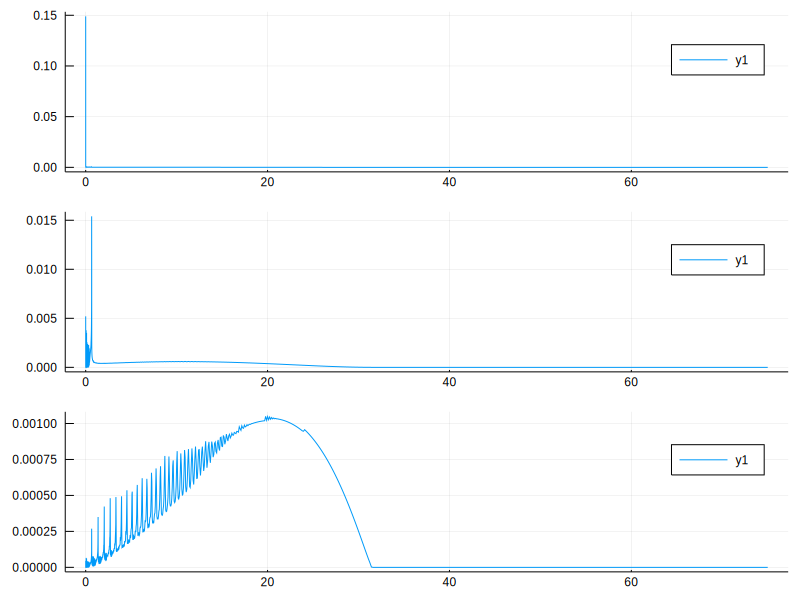

In [12]:
using Plots

plot(
    plot(grid_a_NS,dist[:,1]),
    plot(grid_a_NS,dist[:,2]),
    plot(grid_a_NS,dist[:,3]),
    layout=(3,1),size=(800,600)
)

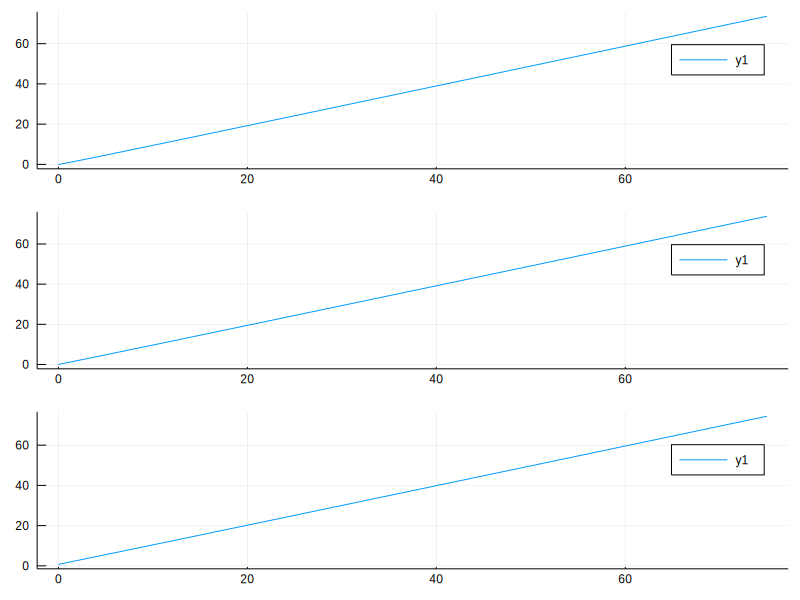

In [13]:
plot(
    plot(grid_a,pf_sav[:,1]),
    plot(grid_a,pf_sav[:,2]),
    plot(grid_a,pf_sav[:,3]),
    layout=(3,1),size=(800,600)
)